<a href="https://colab.research.google.com/github/ruddropust/Research-paper/blob/main/audio%20dises%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install q kaggle

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!mkdir -p ~/.kaggle


In [34]:
!cp /content/drive/MyDrive/ResearchPaper/kaggle.json ~/.kaggle/kaggle.json



In [35]:
! chmod 600 ~/.kaggle/kaggle.json

In [36]:
#!/bin/bash
#!kaggle datasets download vbookshelf/respiratory-sound-database

In [37]:
#!mkdir Dataset

In [38]:
# prompt: save dataset to google drive location /content/drive/MyDrive/ResearchPaper and also Dataset folder coolab

# import shutil

# # Move the downloaded dataset to the specified Google Drive location
# !mkdir -p /content/drive/MyDrive/ResearchPaper/Dataset
# !mv respiratory-sound-database.zip /content/drive/MyDrive/ResearchPaper/Dataset/

# # Copy the downloaded dataset to the Colab Dataset folder
# !mkdir -p Dataset
# !cp /content/drive/MyDrive/ResearchPaper/Dataset/respiratory-sound-database.zip Dataset/

# # Unzip the dataset in both locations
# !unzip /content/drive/MyDrive/ResearchPaper/Dataset/respiratory-sound-database.zip -d /content/drive/MyDrive/ResearchPaper/Dataset/
# !unzip Dataset/respiratory-sound-database.zip -d Dataset/


In [39]:
from os import listdir
import os
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
###
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from tensorflow import keras
###
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout,Input, GlobalAveragePooling2D, Reshape
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf


# Parsing the Dataset

In [40]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis
    self.image_path = image_path

In [41]:
def get_wav_files():
  audio_path = '/content/drive/MyDrive/ResearchPaper/Dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
  files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
  wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files
  wav_files = sorted(wav_files)
  return wav_files, audio_path

In [42]:
def diagnosis_data():
  diagnosis = pd.read_csv('/content/drive/MyDrive/ResearchPaper/Dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv')

  wav_files, audio_path = get_wav_files()
  diag_dict = { 101 : "URTI"}
  diagnosis_list = []

  for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]

  c = 0
  for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))
    c+=1

  return diagnosis_list

# Feature Extraction

In [43]:
def audio_features(filename):
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))

  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate), axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)

  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points():
  labels = []
  images = []

  to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

  count = 0
  for f in diagnosis_data():
    print(count)
    labels.append(to_hot_one[f.diagnosis])
    images.append(audio_features(f.image_path))
    count+=1

  return np.array(labels), np.array(images)

# Preprocessing

In [44]:
def preprocessing(labels, images):

  # Remove Asthma and LRTI
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0)
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # Format new data
  y_train = np.reshape(y_train, (y_train.shape[0], 6))
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], 6))
  X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

  return X_train, X_test, y_train, y_test

## Callbacks

In [45]:
os.makedirs('model/cdd_resnet_aug',exist_ok=True)
save_dir='model/cdd_resnet_aug/cdd_resnet_aug.keras'
checkpoint = keras.callbacks.ModelCheckpoint(save_dir,
                                            monitor='accuracy',
                                            save_best_only=True,
                                            verbose=1,
                                            mode='auto',
                                            save_freq=163)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=20,
                                            mode='auto',
                                            verbose=1,
                                            restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.1,
                                            min_delta=.0001)
csvlogger =  tf.keras.callbacks.CSVLogger('model/cdd_resnet_aug/log.csv',
                                        separator=',',
                                        append=True)
callbacks = [checkpoint, early_stopping, reduce_lr,csvlogger]

In [46]:
# labels, images = data_points()
# X_train, X_test, y_train, y_test = preprocessing(labels, images)

In [47]:
start = timer()

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)


<ipython-input-42-bffff414344c>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diag_dict[row[0]] = row[1]


0


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# MobileNetV2

In [48]:
X_train.shape

(733, 193, 1)

In [49]:
# Step 1: Reshape (733, 193, 1) → (733, 14, 14, 1)
def reshape_features(X):
    X_reshaped = np.zeros((X.shape[0], 14, 14, 1))  # 14x14 grid with 1 channel
    X_reshaped[:, :13, :14, 0] = X[:, :182, 0].reshape(-1, 13, 14)  # Fill with data
    return X_reshaped

X_train_reshaped = reshape_features(X_train)
X_test_reshaped = reshape_features(X_test)

# Step 2: Expand to 3 Channels (For MobileNetV2)
X_train_expanded = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (733, 14, 14, 3)
X_test_expanded = np.repeat(X_test_reshaped, 3, axis=-1)

# Step 3: Resize to MobileNetV2 Input (96×96×3)
X_train_resized = tf.image.resize(X_train_expanded, (96, 96))
X_test_resized = tf.image.resize(X_test_expanded, (96, 96))

# Step 4: Define MobileNetV2 Model
input_tensor = Input(shape=(96, 96, 3))  # MobileNetV2 requires 3 channels
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Step 5: Compile and Train
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)

<ipython-input-49-57afd0ed5181>:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_699']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.5408 - loss: 1.2456 - val_accuracy: 0.8967 - val_loss: 4.3749
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.8606 - loss: 0.4289 - val_accuracy: 0.8967 - val_loss: 8.3034
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8668 - loss: 0.3267 - val_accuracy: 0.8967 - val_loss: 10.0304
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8813 - loss: 0.2756 - val_accuracy: 0.8967 - val_loss: 10.9405
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9042 - loss: 0.2219 - val_accuracy: 0.8967 - val_loss: 11.9837
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9204 - loss: 0.1796 - val_accuracy: 0.8967 - val_loss: 12.2405
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9205 - loss: 0.1897 - val_accuracy: 0.8967 - val_loss: 13.0391
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9236 - loss: 0.1861 - val_accuracy: 0.8967 - val_loss: 

# Evaluation

Accuracy: 90%
Loss: 3.3500



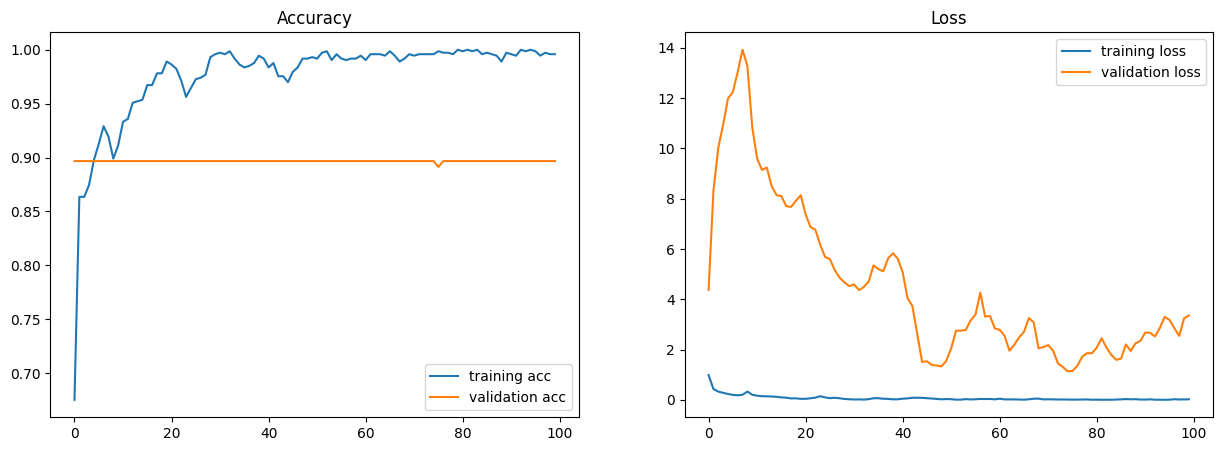

In [50]:
score = model.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

# Custom 1D-CNN + LSTM

In [51]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM, Reshape

model1 = Sequential()

# Add Conv1D layers for feature extraction
model1.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))
model1.add(Conv1D(128, kernel_size=5, activation='relu'))
model1.add(MaxPooling1D(2))

# Add additional Conv1D layer
model1.add(Conv1D(256, kernel_size=5, activation='relu'))

# Add Dropout for regularization
model1.add(Dropout(0.3))

# Reshape the output to 3D for LSTM
model1.add(Reshape((-1, 256)))

# Add LSTM layer for sequential modeling
model1.add(LSTM(128, activation='relu', return_sequences=False))

# Fully connected Dense layers
model1.add(Dense(512, activation='relu'))
model1.add(Dense(6, activation='softmax'))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5612 - loss: 15.5250 - val_accuracy: 0.8967 - val_loss: 0.5681
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8504 - loss: 2.0798 - val_accuracy: 0.8967 - val_loss: 1.0622
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8499 - loss: 5.3336 - val_accuracy: 0.8967 - val_loss: 2.0728
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8587 - loss: 11.0759 - val_accuracy: 0.8967 - val_loss: 3.9258
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8465 - loss: 12.1957 - val_accuracy: 0.8859 - val_loss: 5.9023
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8419 - loss: 18.8367 - val_accuracy: 0.8315 - val_loss: 14.4715
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8222 - loss: 13.3876 - val_accuracy: 0.8804 - val_loss: 15.3425
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7673 - loss: 14.3874 - val_accuracy: 0.8913 - val_loss: 26.23

## Evaluation for Custom 1D-CNN + LSTM

Accuracy: 1%
Loss: nan



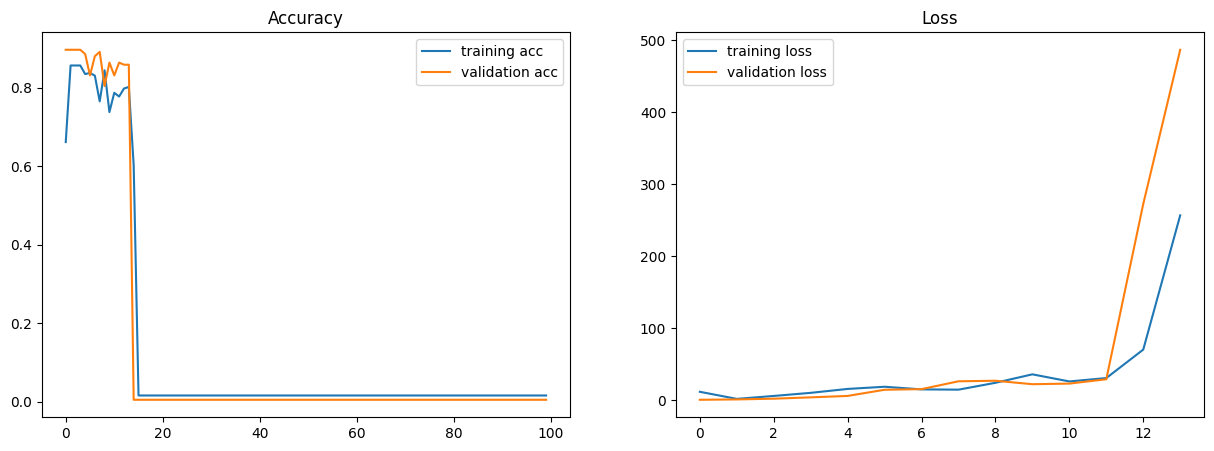

In [52]:
score1 = model1.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score1[1]/1))
print("Loss: %.4f\n" % score1[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history1.history['accuracy'], label = 'training acc')
plt.plot(history1.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history1.history['loss'], label = 'training loss')
plt.plot(history1.history['val_loss'], label = 'validation loss')
plt.legend()

# Spectrogram + ResNet/EfficientNet

In [53]:
X_train.shape

(733, 193, 1)

In [54]:

from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Reshape the input data to match EfficientNetB0's expected input shape
X_train_resized = tf.image.resize(X_train_reshaped, [96, 96])
X_test_resized = tf.image.resize(X_test_reshaped, [96, 96])

# Choose the base model (EfficientNetB0)
input_tensor = Input(shape=(96, 96, 3))
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze pretrained layers
for layer in base_model1.layers:
    layer.trainable = False

# Custom layers
x1 = Flatten()(base_model1.output)
x1 = Dense(512, activation='relu')(x1)
x1 = Dense(6, activation='softmax')(x1)

# Compile the model
model2 = Model(inputs=base_model1.input, outputs=x1)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_902']
Received: inputs=Tensor(shape=(None, 96, 96, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8442 - loss: 3.2758 - val_accuracy: 0.8967 - val_loss: 2.5468
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7881 - loss: 2.5634 - val_accuracy: 0.8370 - val_loss: 1.0554
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8439 - loss: 1.1434 - val_accuracy: 0.8207 - val_loss: 0.6730
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8238 - loss: 0.6964 - val_accuracy: 0.8750 - val_loss: 0.3747
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8398 - loss: 0.4829 - val_accuracy: 0.8967 - val_loss: 0.3592
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8569 - loss: 0.4858 - val_accuracy: 0.9022 - val_loss: 0.3577
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8471 - loss: 0.4694 - val_accuracy: 0.9022 - val_loss: 0.3384
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8598 - loss: 0.4204 - val_accuracy: 0.8859 - val_loss: 0.3600
Epoch

# Evaluation for Spectrogram + ResNet/EfficientNet

Accuracy: 89%
Loss: 0.2715



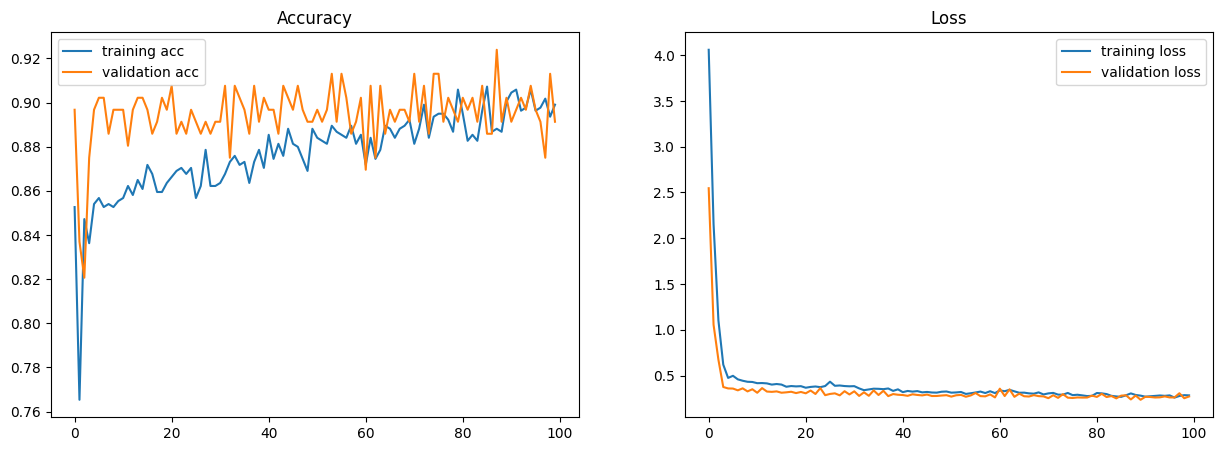

In [55]:
score2 = model2.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score2[1]/1))
print("Loss: %.4f\n" % score2[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label = 'training acc')
plt.plot(history2.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history2.history['loss'], label = 'training loss')
plt.plot(history2.history['val_loss'], label = 'validation loss')
plt.legend()

# Attention-Based CNN Models CBAM

In [56]:
"""
import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Multiply, Reshape
from keras.models import Model

# CBAM Module (Convolutional Block Attention Module)
class CBAM(tf.keras.layers.Layer):
    def __init__(self, channel_attention=True, spatial_attention=True, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = channel_attention
        self.spatial_attention = spatial_attention

    def build(self, input_shape):
        pass

    def call(self, inputs):
        # Channel Attention
        if self.channel_attention:
            channel_avg = tf.reduce_mean(inputs, axis=1, keepdims=True)
            channel_max = tf.reduce_max(inputs, axis=1, keepdims=True)
            channel_attention = tf.sigmoid(channel_avg + channel_max)
            inputs = Multiply()([inputs, channel_attention])

        # Spatial Attention
        if self.spatial_attention:
            spatial_avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
            spatial_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
            spatial_attention = tf.sigmoid(spatial_avg + spatial_max)
            inputs = Multiply()([inputs, spatial_attention])

        return inputs

# Define the attention-based CNN model using CBAM
input_shape = (193, 193, 1)

input_layer = Input(shape=input_shape)
x2 = Reshape((193, 193))(input_layer)  # Reshape to match Conv1D input shape
x2 = Conv1D(64, kernel_size=5, activation='relu')(x2)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(128, kernel_size=5, activation='relu')(x2)
x2 = MaxPooling1D(2)(x2)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(256, kernel_size=5, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = Flatten()(x2)

x2 = Dense(512, activation='relu')(x2)
x2 = Dense(6, activation='softmax')(x2)

model3 = Model(inputs=input_layer, outputs=x2)

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)
"""
import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Multiply
from keras.models import Model

# CBAM Module (Convolutional Block Attention Module)
class CBAM(tf.keras.layers.Layer):
    def __init__(self, channel_attention=True, spatial_attention=True, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = channel_attention
        self.spatial_attention = spatial_attention

    def build(self, input_shape):
        pass

    def call(self, inputs):
        # Channel Attention
        if self.channel_attention:
            channel_avg = tf.reduce_mean(inputs, axis=1, keepdims=True)
            channel_max = tf.reduce_max(inputs, axis=1, keepdims=True)
            channel_attention = tf.sigmoid(channel_avg + channel_max)
            inputs = Multiply()([inputs, channel_attention])

        # Spatial Attention
        if self.spatial_attention:
            spatial_avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
            spatial_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
            spatial_attention = tf.sigmoid(spatial_avg + spatial_max)
            inputs = Multiply()([inputs, spatial_attention])

        return inputs

# Define the attention-based CNN model using CBAM
input_shape = (193, 1)

input_layer = Input(shape=input_shape)
x2 = Conv1D(64, kernel_size=5, activation='relu')(input_layer)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(128, kernel_size=5, activation='relu')(x2)
x2 = MaxPooling1D(2)(x2)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(256, kernel_size=5, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = Flatten()(x2)

x2 = Dense(512, activation='relu')(x2)
x2 = Dense(6, activation='softmax')(x2)

model3 = Model(inputs=input_layer, outputs=x2)

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=200, verbose=1)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4725 - loss: 8.1609 - val_accuracy: 0.8967 - val_loss: 2.3976
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8037 - loss: 4.6315 - val_accuracy: 0.5217 - val_loss: 1.2766
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5550 - loss: 1.5808 - val_accuracy: 0.8967 - val_loss: 0.5108
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8553 - loss: 0.8582 - val_accuracy: 0.8967 - val_loss: 0.4449
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8690 - loss: 0.5571 - val_accuracy: 0.8967 - val_loss: 0.4230
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8646 - loss: 0.5279 - val_accuracy: 0.8967 - val_loss: 0.4092
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8625 - loss: 0.5191 - val_accuracy: 0.8967 - val_loss: 0.4020
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8679 - loss: 0.4852 - val_accuracy: 0.8967 - val_loss: 0

# Evaluation Attention-Based CNN Models CBAM

Accuracy: 96%
Loss: 0.3549



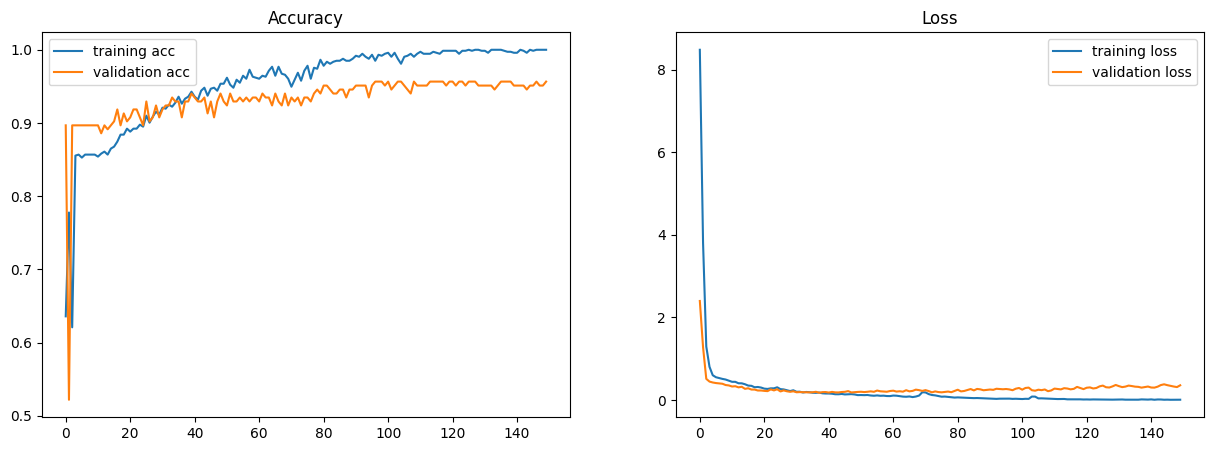

In [59]:
score3 = model3.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score3[1]/1))
print("Loss: %.4f\n" % score3[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label = 'training acc')
plt.plot(history3.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history3.history['loss'], label = 'training loss')
plt.plot(history3.history['val_loss'], label = 'validation loss')
plt.legend()

# OpenL3


In [61]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Use the reshaped and resized data
X_train_resized = tf.image.resize(X_train_reshaped, [193, 193])
X_test_resized = tf.image.resize(X_test_reshaped, [193, 193])

# Load a pretrained EfficientNetB0 model
base_model4 = EfficientNetB0(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model4.trainable = False  # Freeze the base model layers

# Add custom classification layers
model4 = Sequential([
    base_model4,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units to match your classes
])

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history4 = model4.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.4715 - loss: 1.4746 - val_accuracy: 0.8967 - val_loss: 0.6637
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - accuracy: 0.8526 - loss: 0.8918 - val_accuracy: 0.8967 - val_loss: 0.5041
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.8504 - loss: 0.6832 - val_accuracy: 0.8967 - val_loss: 0.5283
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.8584 - loss: 0.6101 - val_accuracy: 0.8967 - val_loss: 0.4755
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.8544 - loss: 0.5766 - val_accuracy: 0.8967 - val_loss: 0.4413
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.8657 - loss: 0.5468 - val_accuracy: 0.8967 - val_loss: 0.4205
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.8555 - loss: 0.5737 - val_accuracy: 0.8967 - val_loss: 0.4235
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.8547 - loss: 0.5547 - val_accuracy: 0.8967 - va

# Evaluation of OpenL3


Accuracy: 90%
Loss: 0.2964



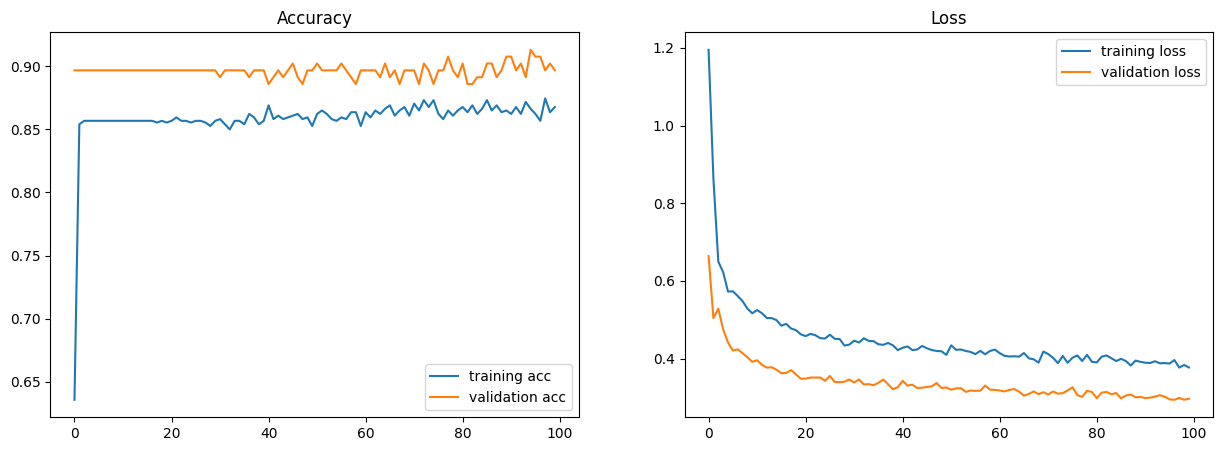

In [63]:
score4 = model4.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score4[1]/1))
print("Loss: %.4f\n" % score4[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history4.history['accuracy'], label = 'training acc')
plt.plot(history4.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history4.history['loss'], label = 'training loss')
plt.plot(history4.history['val_loss'], label = 'validation loss')
plt.legend()

# PANNs (Pre-trained Audio Neural Networks)

In [64]:
# Reshape the data to have 3 channels
X_train_expanded = np.repeat(X_train_reshaped, 3, axis=-1)  # Replicate the 1-channel input to 3 channels
X_test_expanded = np.repeat(X_test_reshaped, 3, axis=-1)    # Same for test data

# Resize the data to match the expected input shape of ResNet50
X_train_resized = tf.image.resize(X_train_expanded, [193, 193])
X_test_resized = tf.image.resize(X_test_expanded, [193, 193])

# Define the model
input_tensor = Input(shape=(193, 193, 3))  # 3 channels (RGB)
base_model5 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom layers
x5 = base_model5.output
x5 = GlobalAveragePooling2D()(x5)
x5 = Dense(512, activation='relu')(x5)
output = Dense(6, activation='softmax')(x5)

# Define the complete model
model5 = Model(inputs=base_model5.input, outputs=output)

# Compile the model
model5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history5 = model5.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100,callbacks=callbacks, batch_size=200, verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1642']
Received: inputs=Tensor(shape=(None, 193, 193, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 173s 22s/step - accuracy: 0.4521 - loss: 1.8708 - val_accuracy: 0.8967 - val_loss: 331.3559 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8649 - loss: 0.5014 - val_accuracy: 0.8967 - val_loss: 44751.1914 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8460 - loss: 0.5937 - val_accuracy: 0.8967 - val_loss: 204653.0469 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8654 - loss: 0.4934 - val_accuracy: 0.8967 - val_loss: 204281.1094 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8492 - loss: 0.5177 - val_accuracy: 0.8967 - val_loss: 146862.1719 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8572 - loss: 0.4910 - val_accuracy: 0.8967 - val_loss: 68549.6094 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8549 - loss: 0.4728 - val_accur

# Evaluation of PANNs (Pre-trained Audio Neural Networks)

Accuracy: 90%
Loss: 331.3559



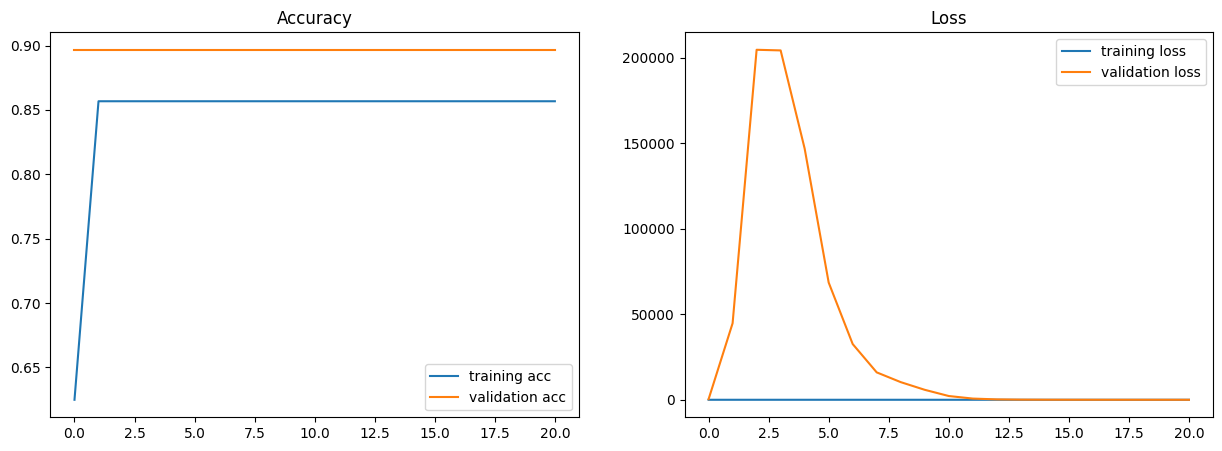

In [65]:
score5 = model5.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score5[1]/1))
print("Loss: %.4f\n" % score5[0])

# # Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history5.history['accuracy'], label = 'training acc')
plt.plot(history5.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history5.history['loss'], label = 'training loss')
plt.plot(history5.history['val_loss'], label = 'validation loss')
plt.legend()

## VGG16

In [72]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Convert grayscale (1-channel) to RGB (3-channel) by repeating across 3 channels
X_train_rgb = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (samples, 193, 193, 3)
X_test_rgb = np.repeat(X_test_reshaped, 3, axis=-1)    # Shape: (samples, 193, 193, 3)

# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained VGG16 model
base_model_vgg = VGG16(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_vgg.trainable = False  # Freeze pretrained layers

# Build the model
model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])

# Compile the model
model_vgg.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history_vgg = model_vgg.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4568 - loss: 3.5627 - val_accuracy: 0.8967 - val_loss: 0.9745
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 951ms/step - accuracy: 0.8324 - loss: 1.5346 - val_accuracy: 0.8696 - val_loss: 0.7110
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7832 - loss: 1.1982 - val_accuracy: 0.8967 - val_loss: 0.5587
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 974ms/step - accuracy: 0.8171 - loss: 1.1646 - val_accuracy: 0.8967 - val_loss: 0.5378
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7920 - loss: 1.1107 - val_accuracy: 0.8967 - val_loss: 0.4837
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 980ms/step - accuracy: 0.7968 - loss: 1.0942 - val_accuracy: 0.8967 - val_loss: 0.5301
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 953ms/step - accuracy: 0.8414 - loss: 1.0963 - val_accuracy: 0.8967 - val_loss: 0.5105
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 945ms/step - accuracy: 0.8157 - loss: 0.8902 - val_accuracy: 0.8967 - val_loss:

### Evaluation of VGG16

Accuracy: 92%
Loss: 0.2384



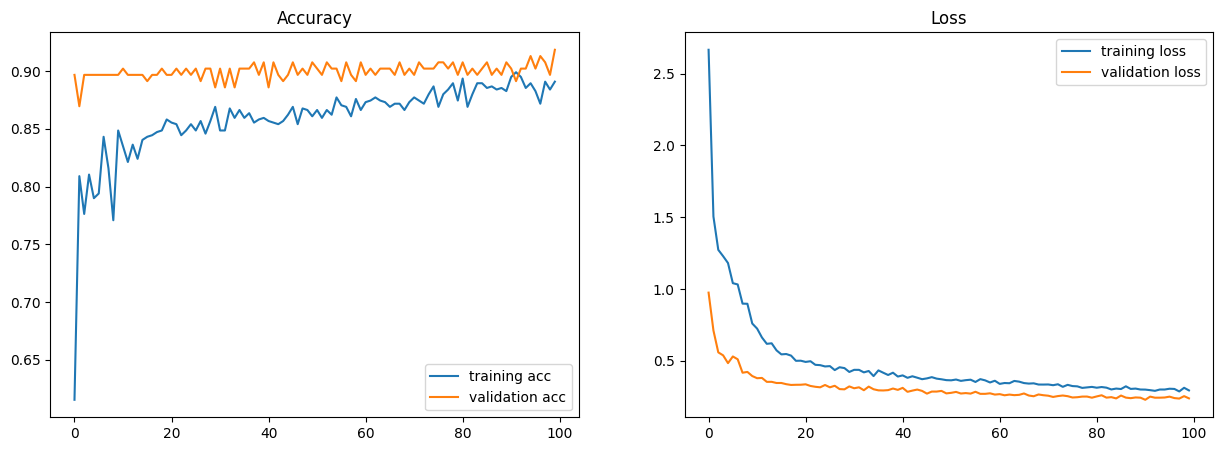

In [73]:
score7 = model_vgg.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score7[1]/1))
print("Loss: %.4f\n" % score7[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vgg.history['accuracy'], label = 'training acc')
plt.plot(history_vgg.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vgg.history['loss'], label = 'training loss')
plt.plot(history_vgg.history['val_loss'], label = 'validation loss')
plt.legend()

In [74]:
print('Accuracy: {0:.0%}'.format(score7[1]/1))
print("Loss: %.4f\n" % score7[0])

Accuracy: 92%
Loss: 0.2384



## VGG19

In [76]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Convert grayscale (1-channel) to RGB (3-channel) by repeating across 3 channels
X_train_rgb = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (samples, 193, 193, 3)
X_test_rgb = np.repeat(X_test_reshaped, 3, axis=-1)    # Shape: (samples, 193, 193, 3)

# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained VGG16 model
base_model_vgg19 = VGG19(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_vgg19.trainable = False  # Freeze pretrained layers

# Build the model
model_vgg19 = Sequential([
    base_model_vgg19,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])

# Compile the model
model_vgg19.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history_vgg19 = model_vgg19.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4759 - loss: 3.4642 - val_accuracy: 0.8967 - val_loss: 1.4220
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8584 - loss: 2.1236 - val_accuracy: 0.8967 - val_loss: 0.9240
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7822 - loss: 1.6546 - val_accuracy: 0.8587 - val_loss: 0.7025
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7611 - loss: 1.4345 - val_accuracy: 0.8967 - val_loss: 0.5674
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8288 - loss: 1.1630 - val_accuracy: 0.8859 - val_loss: 0.5555
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7744 - loss: 0.9971 - val_accuracy: 0.8967 - val_loss: 0.4939
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8326 - loss: 0.8290 - val_accuracy: 0.8967 - val_loss: 0.4690
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8299 - loss: 0.8120 - val_accuracy: 0.8967 - val_loss: 0.3968
Epoch 

### Evaluation of VGG19

Accuracy: 91%
Loss: 0.2404



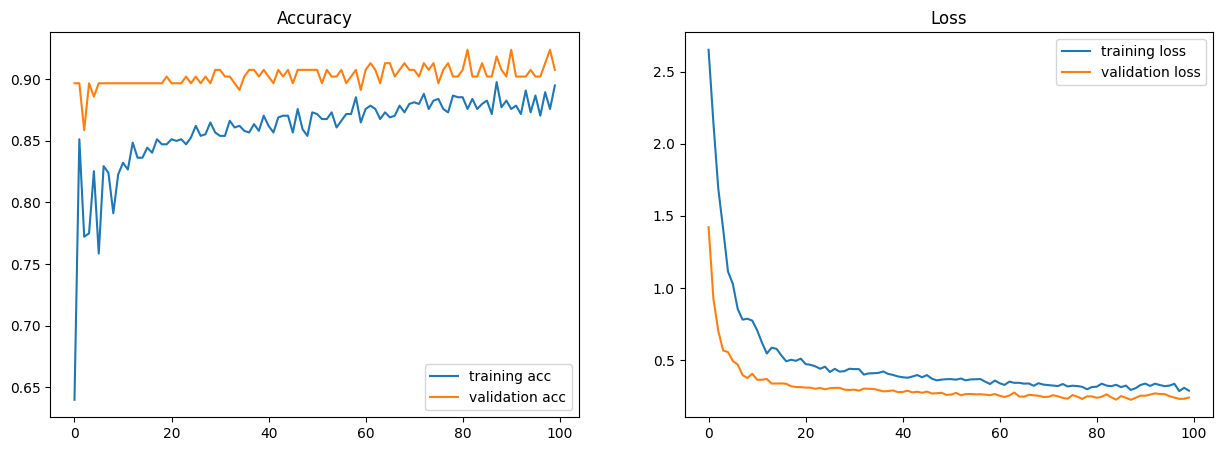

In [77]:
score8 = model_vgg19.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score8[1]/1))
print("Loss: %.4f\n" % score8[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vgg19.history['accuracy'], label = 'training acc')
plt.plot(history_vgg19.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vgg19.history['loss'], label = 'training loss')
plt.plot(history_vgg19.history['val_loss'], label = 'validation loss')
plt.legend()

## ResNet50

In [79]:
from tensorflow.keras.applications import ResNet50


# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained VGG16 model
base_model_resNet50 = ResNet50(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_resNet50.trainable = False  # Freeze pretrained layers


# Compile the model
model9 = Sequential([
    base_model_resNet50,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history9 = model9.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.4531 - loss: 2.0155 - val_accuracy: 0.8967 - val_loss: 1.0086
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 612ms/step - accuracy: 0.8425 - loss: 1.2425 - val_accuracy: 0.8750 - val_loss: 0.6922
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.8160 - loss: 0.9485 - val_accuracy: 0.8967 - val_loss: 0.4916
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.8538 - loss: 0.7859 - val_accuracy: 0.8967 - val_loss: 0.3898
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.8584 - loss: 0.6124 - val_accuracy: 0.8967 - val_loss: 0.3627
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.8635 - loss: 0.5547 - val_accuracy: 0.8913 - val_loss: 0.3644
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - accuracy: 0.8604 - loss: 0.4885 - val_accuracy: 0.8967 - val_loss: 0.3385
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.8672 - loss: 0.4634 - val_accuracy: 0.8967 - val

## Evaluation of ResNet50

Accuracy: 91%
Loss: 0.2260



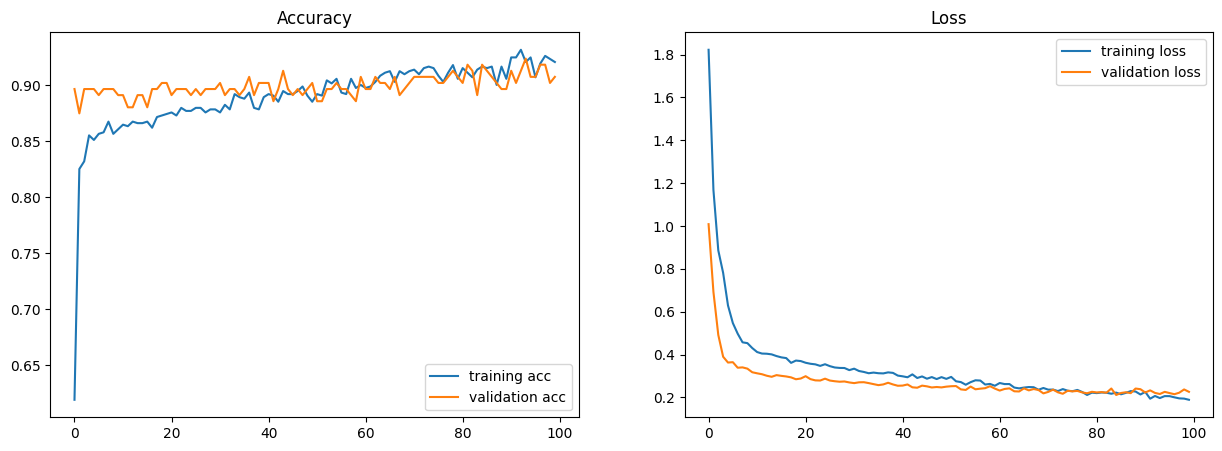

In [80]:
score9 = model9.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score9[1]/1))
print("Loss: %.4f\n" % score9[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history9.history['accuracy'], label = 'training acc')
plt.plot(history9.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history9.history['loss'], label = 'training loss')
plt.plot(history9.history['val_loss'], label = 'validation loss')
plt.legend()

## ResNet101

In [81]:
from tensorflow.keras.applications import ResNet101, ResNet101V2
import numpy as np
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)

# Load ResNet101 and ResNet101V2 models with ImageNet weights, excluding the top classification layers
base_model10 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_model11 = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model10.layers:
    layer.trainable = False

for layer in base_model11.layers:
    layer.trainable = False

# Custom layers for ResNet101
x10 = Flatten()(base_model10.output)
x10 = Dense(512, activation='relu')(x10)
output10 = Dense(6, activation='softmax')(x10)

# Custom layers for ResNet101V2
x11 = Flatten()(base_model11.output)
x11 = Dense(512, activation='relu')(x11)
output11 = Dense(6, activation='softmax')(x11)

# Compile the models
model10 = Model(inputs=base_model10.input, outputs=output10)
model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model11 = Model(inputs=base_model11.input, outputs=output11)
model11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
history10 = model10.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)
history11 = model11.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)


Epoch 1/100


ValueError: Input 0 of layer "functional_35" is incompatible with the layer: expected shape=(None, 193, 193, 3), found shape=(None, 193, 9)

## Evaluation of ResNet101

In [ ]:
score10 = model10.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score10[1]/1))
print("Loss: %.4f\n" % score10[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history10.history['accuracy'], label = 'training acc')
plt.plot(history10.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history10.history['loss'], label = 'training loss')
plt.plot(history10.history['val_loss'], label = 'validation loss')
plt.legend()

## Evaluation of ResNet101V2

In [ ]:
score11 = model11.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score10[1]/1))
print("Loss: %.4f\n" % score11[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history11.history['accuracy'], label = 'training acc')
plt.plot(history11.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history11.history['loss'], label = 'training loss')
plt.plot(history11.history['val_loss'], label = 'validation loss')
plt.legend()

## EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetV2L

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)

# Load EfficientNetV2L model with ImageNet weights, excluding the top classification layers
base_model12 = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model12.layers:
    layer.trainable = False

# Custom layers
x12 = Flatten()(base_model12.output)
x12 = Dense(512, activation='relu')(x12)
output12 = Dense(6, activation='softmax')(x12)

# Compile the model
model12 = Model(inputs=base_model12.input, outputs=output12)
model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history12 = model12.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)

## Evaluation of EfficientNetV2L

In [ ]:
score12 = model12.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score12[1]/1))
print("Loss: %.4f\n" % score12[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history12.history['accuracy'], label = 'training acc')
plt.plot(history12.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history12.history['loss'], label = 'training loss')
plt.plot(history12.history['val_loss'], label = 'validation loss')
plt.legend()

## DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet169

# Adjust the input shape to have 3 channels
X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)

# Load DenseNet169 model with ImageNet weights, excluding the top classification layers
base_model13 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model13.layers:
    layer.trainable = False

# Custom layers
x13 = Flatten()(base_model13.output)
x13 = Dense(512, activation='relu')(x13)
output13 = Dense(6, activation='softmax')(x13)

# Compile the model
model13 = Model(inputs=base_model13.input, outputs=output13)
model13.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history13 = model13.fit(X_train_vgg1, y_train, validation_data=(X_test_vgg1, y_test), callbacks=callbacks, epochs=100, batch_size=200, verbose=1)

## Evaluation of DenseNet169

In [ ]:
score13 = model13.evaluate(X_test_vgg1, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score13[1]/1))
print("Loss: %.4f\n" % score13[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history13.history['accuracy'], label = 'training acc')
plt.plot(history13.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history13.history['loss'], label = 'training loss')
plt.plot(history13.history['val_loss'], label = 'validation loss')
plt.legend()

# WaveNet

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Activation, Add

# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# WaveNet-style causal convolutional block
def residual_block(x, dilation_rate):
    res = x
    x = Conv1D(filters=64, kernel_size=2, padding="causal", dilation_rate=dilation_rate, activation="relu")(x)
    x = Conv1D(filters=64, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(x)
    x = Add()([x, res])  # Residual connection
    x = Activation("relu")(x)
    return x

# Input layer
inputs = Input(shape=input_shape)

# First convolution (non-causal)
x = Conv1D(filters=64, kernel_size=2, padding="same", activation="relu")(inputs)

# Stack of residual blocks with increasing dilation rates
dilations = [1, 2, 4, 8, 16, 32]
for dilation in dilations:
    x = residual_block(x, dilation)

# Flatten and output layer
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_wavenet = Model(inputs, outputs)
model_wavenet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_wavenet = model_wavenet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)

## Efficiency of WaveNet

In [ ]:
score_waveNet = model_wavenet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_waveNet[1]/1))
print("Loss: %.4f\n" % score_waveNet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_wavenet.history['accuracy'], label = 'training acc')
plt.plot(history_wavenet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_wavenet.history['loss'], label = 'training loss')
plt.plot(history_wavenet.history['val_loss'], label = 'validation loss')
plt.legend()

## SoundNet

In [ ]:
# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# Input layer
inputs = Input(shape=input_shape)

# SoundNet-style convolutional layers
x = Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)

# Flatten and classification layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_soundnet = Model(inputs, outputs)
model_soundnet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_soundnet = model_soundnet.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=100, batch_size=200, verbose=1)


### Efficiency of soundNet

In [ ]:
score_soundNet = model_soundnet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_soundNet[1]/1))
print("Loss: %.4f\n" % score_soundNet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_soundnet.history['accuracy'], label = 'training acc')
plt.plot(history_soundnet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_soundnet.history['loss'], label = 'training loss')
plt.plot(history_soundnet.history['val_loss'], label = 'validation loss')
plt.legend()

## VGGish

In [ ]:

from tensorflow.keras.layers import BatchNormalization, Dropout


# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# Input layer
inputs = Input(shape=input_shape)

# VGGish-style convolutional layers
x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Flatten and fully connected layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_vggish = Model(inputs, outputs)
model_vggish.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_vggish = model_vggish.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


## Efficiency of VGGish

In [ ]:
score_vggish = model_vggish.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_vggish[1]/1))
print("Loss: %.4f\n" % score_vggish[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vggish.history['accuracy'], label = 'training acc')
plt.plot(history_vggish.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vggish.history['loss'], label = 'training loss')
plt.plot(history_vggish.history['val_loss'], label = 'validation loss')
plt.legend()

## DenseNet Manually

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D
# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:
    X_train = np.mean(X_train, axis=-1, keepdims=True)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# DenseNet-style Dense Block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        conv = Conv1D(filters=growth_rate, kernel_size=3, padding="same", activation="relu")(x)
        conv = BatchNormalization()(conv)
        x = tf.keras.layers.Concatenate()([x, conv])  # Dense connection
    return x

# Transition Layer (reduces dimensions)
def transition_layer(x, reduction=0.5):
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = Conv1D(filters, kernel_size=1, activation="relu")(x)
    x = BatchNormalization()(x)
    return x

# Input layer
inputs = Input(shape=input_shape)

# Initial Conv Layer
x = Conv1D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(inputs)
x = BatchNormalization()(x)

# Dense Blocks + Transition Layers
x = dense_block(x, num_layers=4, growth_rate=32)
x = transition_layer(x)

x = dense_block(x, num_layers=6, growth_rate=32)
x = transition_layer(x)

x = dense_block(x, num_layers=8, growth_rate=32)

# Global Average Pooling & Output Layer
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_densenet = Model(inputs, outputs)
model_densenet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_densenet = model_densenet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)

## Efficiency of DenseNet

In [ ]:
score_densenet = model_densenet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_densenet[1]/1))
print("Loss: %.4f\n" % score_densenet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_densenet.history['accuracy'], label = 'training acc')
plt.plot(history_densenet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_densenet.history['loss'], label = 'training loss')
plt.plot(history_densenet.history['val_loss'], label = 'validation loss')
plt.legend()

In [ ]:

# matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

# preds = model.predict(X_test)
# classpreds = np.argmax(preds, axis=1) # predicted classes
# y_testclass = np.argmax(y_test, axis=1) # true classes

# cm = confusion_matrix(y_testclass, classpreds)
# print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# # Get percentage value for each element of the matrix
# cm_sum = np.sum(cm, axis=1, keepdims=True)
# cm_perc = cm / cm_sum.astype(float) * 100
# annot = np.empty_like(cm).astype(str)
# nrows, ncols = cm.shape
# for i in range(nrows):
#     for j in range(ncols):
#         c = cm[i, j]
#         p = cm_perc[i, j]
#         if i == j:
#             s = cm_sum[i]
#             annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
#         elif c == 0:
#             annot[i, j] = ''
#         else:
#             annot[i, j] = '%.1f%%\n%d' % (p, c)


# # Display confusion matrix
# df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# fig, ax = plt.subplots(figsize=(10,7))
# sn.heatmap(df_cm, annot=annot, fmt='')